In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [4]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-04 10:15:46,287 INFO: Initializing external client
2025-03-04 10:15:46,289 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-04 10:15:47,501 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215681


In [5]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1215681/featurestores/1203305/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [7]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 
2025-03-04 10:15:58,037 WARNING: VersionWarning: Incremented version to `8`.



In [8]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [9]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2025-02-03 05:00:00+00:00,2,0
1,2025-02-03 06:00:00+00:00,2,0
2,2025-02-03 07:00:00+00:00,2,0
3,2025-02-03 08:00:00+00:00,2,0
4,2025-02-03 09:00:00+00:00,2,0


In [10]:
ts_data["pickup_hour"].min()

'2025-02-03 05:00:00+00:00'

In [11]:
ts_data["pickup_hour"].max()

'2025-03-04 14:00:00+00:00'

In [12]:
ts_data_copy = ts_data.copy()

In [13]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [14]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177206 entries, 0 to 177205
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   pickup_hour         177206 non-null  datetime64[ns, UTC]
 1   pickup_location_id  177206 non-null  int32              
 2   rides               177206 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 2.7 MB


In [15]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [16]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177206 entries, 0 to 177205
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pickup_hour         177206 non-null  datetime64[ns]
 1   pickup_location_id  177206 non-null  int32         
 2   rides               177206 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 2.7 MB


In [17]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [18]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2025-02-03 05:00:00,2,0,2025-02
1,2025-02-03 06:00:00,2,0,2025-02
2,2025-02-03 07:00:00,2,0,2025-02
3,2025-02-03 08:00:00,2,0,2025-02
4,2025-02-03 09:00:00,2,0,2025-02
...,...,...,...,...
177201,2025-03-04 10:00:00,263,116,2025-03
177202,2025-03-04 11:00:00,263,98,2025-03
177203,2025-03-04 12:00:00,263,100,2025-03
177204,2025-03-04 13:00:00,263,100,2025-03


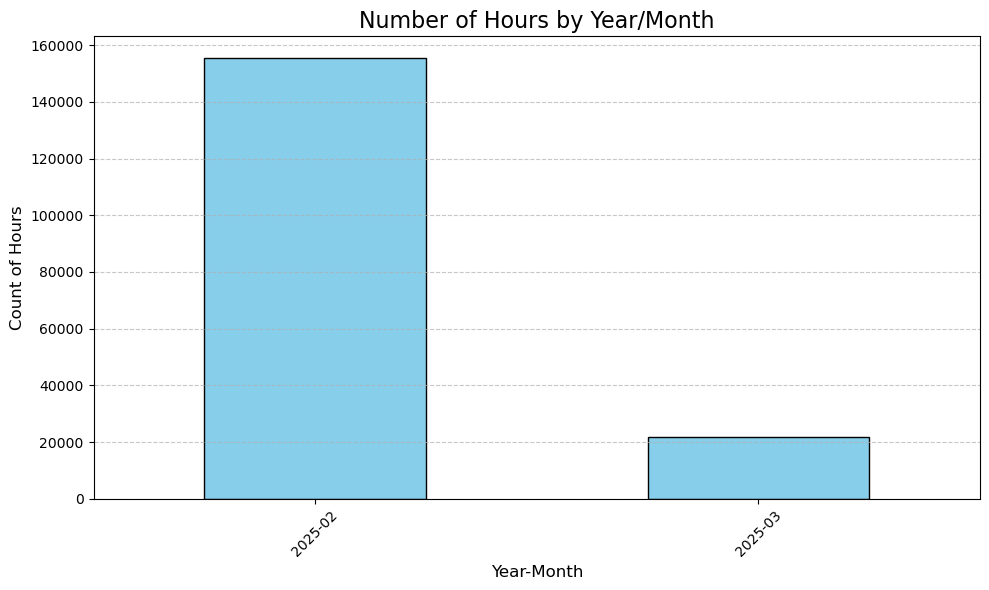

In [19]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [21]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2025-02-03 05:00:00,2,0,2025-02
1,2025-02-03 06:00:00,2,0,2025-02
2,2025-02-03 07:00:00,2,0,2025-02
3,2025-02-03 08:00:00,2,0,2025-02
4,2025-02-03 09:00:00,2,0,2025-02


In [22]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [23]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [25]:
filtered_data.shape

(0, 3)

In [22]:
ts_data = filtered_data

In [26]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177206 entries, 0 to 177205
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pickup_hour         177206 non-null  datetime64[ns]
 1   pickup_location_id  177206 non-null  int32         
 2   rides               177206 non-null  int32         
 3   year_month          177206 non-null  period[M]     
dtypes: datetime64[ns](1), int32(2), period[M](1)
memory usage: 4.1 MB


In [27]:
ts_data.head()["pickup_hour"].values

array(['2025-02-03T05:00:00.000000000', '2025-02-03T06:00:00.000000000',
       '2025-02-03T07:00:00.000000000', '2025-02-03T08:00:00.000000000',
       '2025-02-03T09:00:00.000000000'], dtype='datetime64[ns]')

In [29]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [32]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-03-03 05:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-03-04 04:00:00,2
2,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,2025-03-03 05:00:00,3
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-03-04 04:00:00,3
4,0,2,3,3,4,6,2,2,2,4,...,1,1,3,1,0,1,2,0,2025-03-03 05:00:00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2,2,0,4,5,16,21,34,25,31,...,22,21,8,10,1,0,0,1,2025-03-04 04:00:00,261
498,14,52,136,149,139,98,76,87,70,71,...,23,7,9,5,1,1,2,9,2025-03-03 05:00:00,262
499,3,19,63,126,177,156,102,81,88,81,...,37,16,14,9,2,2,1,4,2025-03-04 04:00:00,262
500,18,44,120,133,96,112,93,97,92,122,...,67,45,17,12,13,3,4,9,2025-03-03 05:00:00,263


In [35]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-03-03 05:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-03-04 04:00:00,2


In [37]:
features_copy = features.copy()

In [38]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(502, 675)

In [39]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-04 10:16:06.025872')

In [40]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(0, 674)
(0,)
(502, 674)
(502,)


In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 132.0 bytes


In [44]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [46]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23743
[LightGBM] [Info] Number of data points in the train set: 502, number of used features: 675
[LightGBM] [Info] Start training from score 1.677291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x0000028E6B327240>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [49]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [51]:
predictions

array([-2.29148683e-02, -8.75904280e-03,  6.64953175e-02,  2.96020346e-02,
        8.09399612e-01, -1.28770236e-01,  3.36468134e-02,  7.42813407e-02,
        1.02829645e+00,  4.31290095e-02, -5.06565796e-02, -7.56201282e-03,
        8.28355725e-02, -9.10242047e-03,  1.97128383e+00, -1.58523513e-02,
        7.98744410e-01,  5.47714895e-02,  3.23839904e-02, -2.17429875e-02,
        1.01572809e+00, -4.35985258e-02,  9.94689412e-01,  1.02041226e+00,
        8.29479589e-01, -2.74465527e-02,  1.59610226e-02,  6.05794269e-03,
        1.05386201e+00,  1.94057020e+00, -4.86885981e-02,  9.35317482e-01,
        5.41793639e-02,  8.25935135e-01,  1.55083707e+00,  4.06272170e-02,
        9.34233151e-01,  5.58596051e-03,  9.78796561e-01,  3.63008503e-03,
       -4.27025611e-02,  4.47938266e-03,  3.08639230e+00,  9.68538231e-01,
        1.01468909e-01,  1.21777005e-02,  6.24682058e-02, -9.98320578e-03,
       -2.77843084e-02, -8.75904280e-03,  1.02838711e+00,  7.66845187e-02,
        2.92745454e-02, -

In [52]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

0.2584


In [53]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['E:\\ms fall 2024\\sping 2025\\MLOPS\\sp25_taxi-main\\models\\lgb_model.pkl']

In [54]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [56]:
# Instantiate the model registry
model_registry = project.get_model_registry()

# Create a model in the model registry without the unsupported 'include_files' argument
model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema
)

# Save the model to a path within your Hopsworks project or local directory
model.save('E:\\ms fall 2024\\sping 2025\\MLOPS\\sp25_taxi-main\\models\\lgb_model.pkl')

# Optionally, print the URL to access the model in Hopsworks
print("Model saved successfully. Access it at:", model.get_url())


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/220936 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2049 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/51418 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1215681/models/taxi_demand_predictor_next_hour/2
Model saved successfully. Access it at: https://c.app.hopsworks.ai:443/p/1215681/models/taxi_demand_predictor_next_hour/2


In [57]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-03-04 10:16:23,524 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-04 10:16:26,544 INFO: Initializing external client
2025-03-04 10:16:26,545 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-04 10:16:27,613 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215681


In [59]:
from src.inference import get_model_predictions

In [62]:
preds = get_model_predictions(model, features_copy)

In [64]:
model.get_m

2025-03-04 10:16:31,807 WARNING: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

2025-03-04 10:16:31,808 WARNING: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead



AttributeError: 'Pipeline' object has no attribute 'get_m'

In [65]:
preds

,pickup_location_id,predicted_demand
0,2,-0.0
1,2,-0.0
2,3,0.0
3,3,0.0
4,4,1.0
...,...,...
497,261,1.0
498,262,17.0
499,262,5.0
500,263,15.0


In [67]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

0.2092
